In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
data = pd.read_csv('../data/imf.csv',index_col=0,encoding = "utf-8")

In [19]:
print(list(data.columns))

['Year', 'ISO-3 code', 'Institutions of commercial banks', 'Number of credit unions and credit cooperatives', 'Number of deposit-taking microfinance institutions', 'Number of other deposit takers', 'Number of non-deposit taking microfinance institutions', 'Number of insurance corporations', 'Branches of commercial banks', 'Branches of credit unions and credit cooperatives', 'Branches of deposit taking MFIs', 'Branches of other deposit takers', 'Branches of non-deposit taking microfinance institutions', 'Number of non-branch retail agent outlets of commercial banks', 'Automated Teller Machines (ATMs)', 'Number of registered mobile money agent outlets', 'Number of active mobile money agent outlets', 'Depositors with commercial banks', 'Depositors with commercial banks: o/w SME', 'Depositors with commercial banks: o/w household sector', 'Depositors with commercial banks: o/w household: o/w male', 'Depositors with commercial banks: o/w household: o/w female', 'Depositors with credit unions

In [20]:
data_comp = data.loc[['India','Myanmar','Portugal','Hungary','Mexico','Turkey','Bangladesh']]

<AxesSubplot:xlabel='Year', ylabel='Non-life insurance policies per 1,000 adults'>

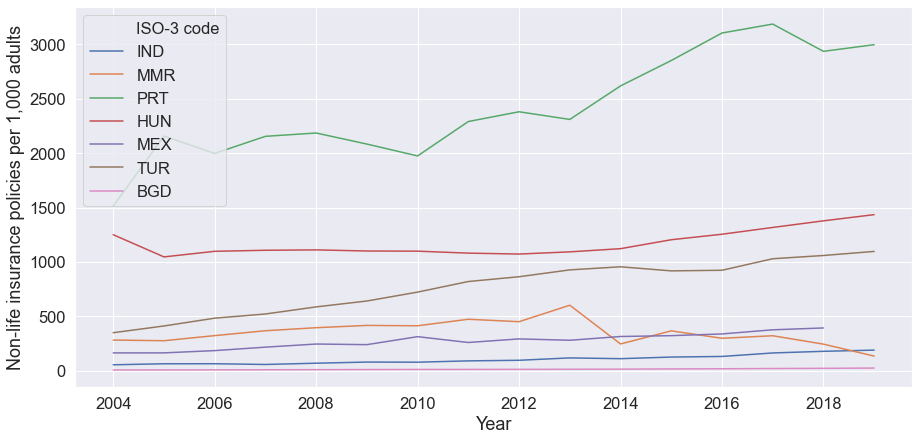

In [21]:
sns.set(font_scale=1.5)
plt.figure(figsize=(15,7))
sns.lineplot(x='Year',y='Non-life insurance policies per 1,000 adults',hue='ISO-3 code',data=data_comp)

# Synthetic Control w/ Lasso

In [22]:
import sklearn.linear_model as lm

In [23]:
# time_intervention = 2016
# target = 'India'
# series = 'Non-life insurance policies per 1,000 adults'
# donors = ['Myanmar','Portugal','Hungary','Mexico','Turkey','Bangladesh']
def setup(target,donors,series,time_intervention,data):
    pre_intervention = data.loc[data['Year']<time_intervention]
    post_intervenion = data.loc[data['Year']>=time_intervention]
    Y_target = pd.DataFrame(data.loc[target,series].to_numpy(),index=data['Year'].unique(),columns=[target])
    Y_donor = (pd.DataFrame([data.loc[donor,series].to_numpy() for donor in donors],index=donors,columns=data['Year'].unique()).T).dropna(axis=1)#.fillna(method='ffill').fillna(method='bfill')
    Ypre_target = Y_target.loc[Y_target.index<time_intervention] #pre_intervention.loc[target,series].fillna(method='ffill').fillna(method='bfill').to_numpy()
    Ypre_donor = Y_donor.loc[Y_donor.index<time_intervention] #(pd.DataFrame([pre_intervention.loc[donor,series].to_numpy() for donor in donors],index=donors).T).fillna(method='ffill').fillna(method='bfill')
    return Ypre_target,Ypre_donor,Y_target,Y_donor

## Non-life insurance policies per 1,000 adults

In [24]:
time_intervention = 2016
target = 'India'
series = 'Non-life insurance policies per 1,000 adults'
# donors = ['Myanmar','Portugal','Hungary','Mexico','Turkey','Bangladesh']
donors = [ 'Argentina', 'Armenia, Rep. of', 'Bangladesh', 'Barbados', 'Belarus, Rep. of', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 
          'Brunei Darussalam', 'Cambodia', 'Cameroon', 'Chile', 'China, P.R.: Macao', 'China, P.R.: Mainland', 'Colombia', 'Costa Rica', 'Cyprus', 
          'Egypt, Arab Rep. of', 'Fiji, Rep. of', 'Georgia', 'Guinea', 'Honduras', 'Hungary', 'Jamaica', 'Japan', 'Jordan', 
          'Kazakhstan, Rep. of', 'Korea, Rep. of', 'Kosovo, Rep. of', "Lao People's Dem. Rep.", 'Latvia', 'Lebanon', 'Lesotho, Kingdom of', 
          'Maldives', 'Mauritius', 'Mexico', 'Moldova, Rep. of', 'Montenegro', 'Myanmar', 'Nicaragua', 'North Macedonia, Republic of', 'Pakistan', 
          'Poland, Rep. of', 'Portugal', 'Romania', 'Russian Federation', 'Rwanda', 'Samoa', 'São Tomé and Príncipe, Dem. Rep. of', 'Saudi Arabia', 
          'Serbia, Rep. of', 'Seychelles', 'Slovak Rep.', 'Suriname', 'Thailand', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Ukraine', 'Vanuatu', 
          'Zambia']
Ypre_target,Ypre_donor,Y_target,Y_donor = setup(target,donors,series,time_intervention,data)

In [25]:
m_ridge = lm.RidgeCV().fit(Ypre_donor,Ypre_target)
m_lasso = lm.LassoCV().fit(Ypre_donor,Ypre_target)
m_bayesian = lm.BayesianRidge().fit(Ypre_donor,Ypre_target)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [26]:
Y_target_ridge = m_ridge.predict(Y_donor.fillna(method='ffill'))
Y_target_lasso = m_lasso.predict(Y_donor.fillna(method='ffill'))
Y_target_bayesian,std_y_target_bayesian = m_bayesian.predict(Y_donor.fillna(method='ffill'),return_std=True)

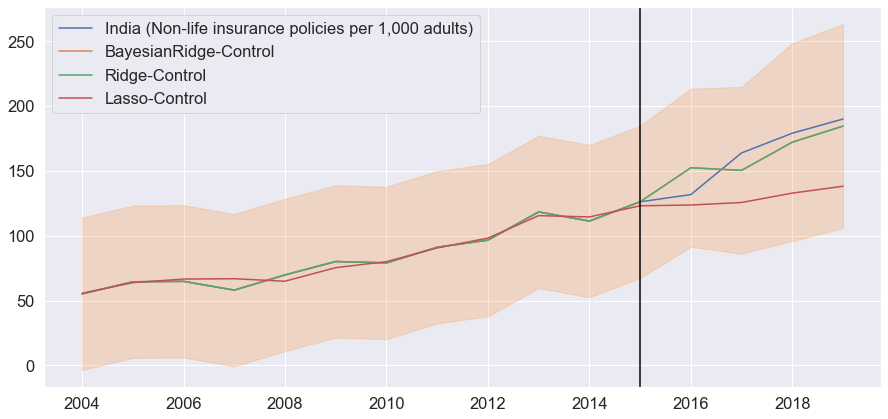

In [27]:
fig = plt.figure(figsize=(15,7))
plt.plot(np.arange(2004,2020),Y_target)
plt.plot(np.arange(2004,2020),Y_target_bayesian)
plt.plot(np.arange(2004,2020),Y_target_ridge)
plt.plot(np.arange(2004,2020),Y_target_lasso)

plt.fill_between(np.arange(2004,2020),Y_target_bayesian+std_y_target_bayesian,Y_target_bayesian-std_y_target_bayesian,alpha=0.2,color='#ff7f0e')
plt.axvline(2015,c='black')
plt.legend(['%s (%s)'%(target,series),'BayesianRidge-Control','Ridge-Control','Lasso-Control'])

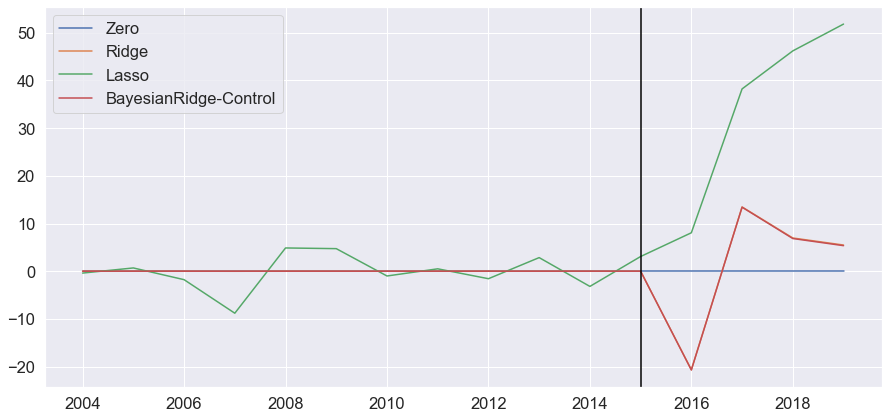

In [28]:
fig = plt.figure(figsize=(15,7))
plt.plot(np.arange(2004,2020),Y_target-Y_target)
plt.plot(np.arange(2004,2020),Y_target-Y_target_ridge)
plt.plot(np.arange(2004,2020),(Y_target.to_numpy().T-Y_target_lasso).T)
plt.plot(np.arange(2004,2020),(Y_target.to_numpy().T-Y_target_bayesian).T)
plt.axvline(2015,c='black')
plt.legend(['Zero','Ridge','Lasso','BayesianRidge-Control'])

<AxesSubplot:>

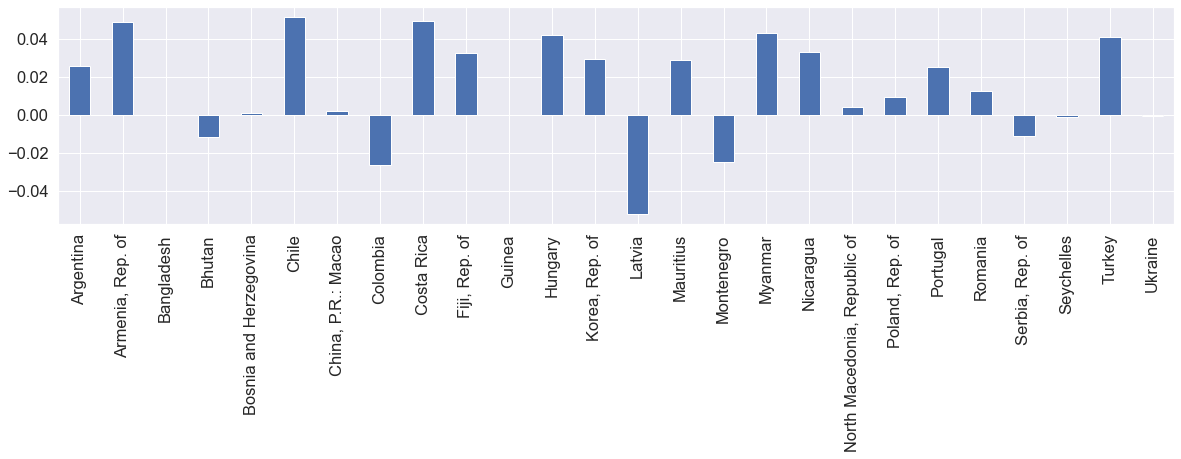

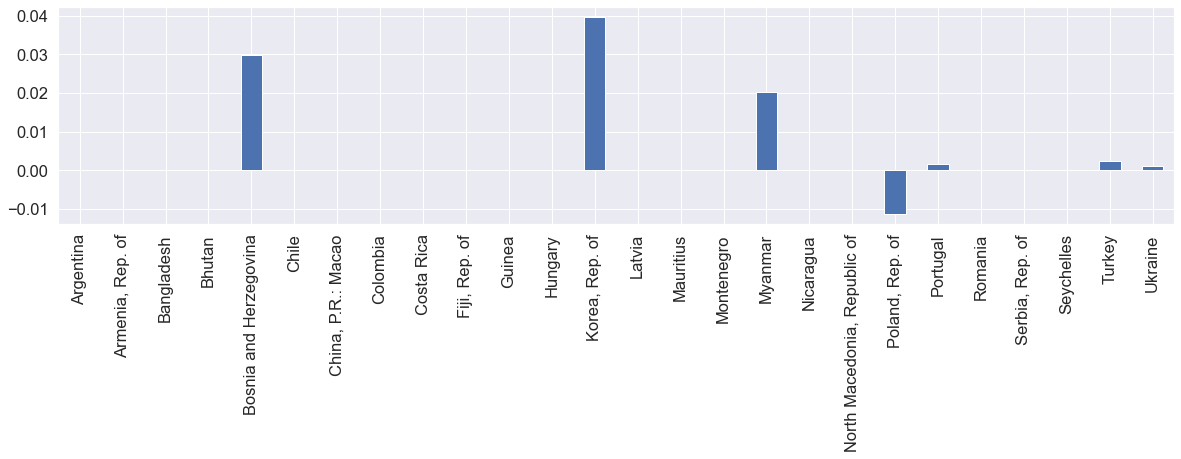

In [29]:
fig = plt.figure(figsize=(20,4))
pd.Series(m_bayesian.coef_,index=Y_donor.columns).plot(kind='bar')
fig = plt.figure(figsize=(20,4))
pd.Series(m_lasso.coef_,index=Y_donor.columns).plot(kind='bar')

## Deposit accounts with commercial banks: o/w household sector

In [37]:
time_intervention = 2016
target = 'India'
series = 'Deposit accounts with commercial banks: o/w household sector'
# donors = ['Myanmar','Portugal','Hungary','Mexico','Turkey','Bangladesh']
donors = [ 'Argentina', 'Armenia, Rep. of', 'Bangladesh', 'Barbados', 'Belarus, Rep. of', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 
          'Brunei Darussalam', 'Cambodia', 'Cameroon', 'Chile', 'China, P.R.: Macao', 'China, P.R.: Mainland', 'Colombia', 'Costa Rica', 'Cyprus', 
          'Egypt, Arab Rep. of', 'Fiji, Rep. of', 'Georgia', 'Guinea', 'Honduras', 'Hungary', 'Jamaica', 'Japan', 'Jordan', 
          'Kazakhstan, Rep. of', 'Korea, Rep. of', 'Kosovo, Rep. of', "Lao People's Dem. Rep.", 'Latvia', 'Lebanon', 'Lesotho, Kingdom of', 
          'Maldives', 'Mauritius', 'Mexico', 'Moldova, Rep. of', 'Montenegro', 'Myanmar', 'Nicaragua', 'North Macedonia, Republic of', 'Pakistan', 
          'Poland, Rep. of', 'Portugal', 'Romania', 'Russian Federation', 'Rwanda', 'Samoa', 'São Tomé and Príncipe, Dem. Rep. of', 'Saudi Arabia', 
          'Serbia, Rep. of', 'Seychelles', 'Slovak Rep.', 'Suriname', 'Thailand', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Ukraine', 'Vanuatu', 
          'Zambia']
Ypre_target,Ypre_donor,Y_target,Y_donor = setup(target,donors,series,time_intervention,data)

In [38]:
m_ridge = lm.RidgeCV().fit(Ypre_donor,Ypre_target)
m_lasso = lm.LassoCV().fit(Ypre_donor,Ypre_target)
m_bayesian = lm.BayesianRidge().fit(Ypre_donor,Ypre_target)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
Y_target_ridge = m_ridge.predict(Y_donor.fillna(method='ffill'))
Y_target_lasso = m_lasso.predict(Y_donor.fillna(method='ffill'))
Y_target_bayesian,std_y_target_bayesian = m_bayesian.predict(Y_donor.fillna(method='ffill'),return_std=True)

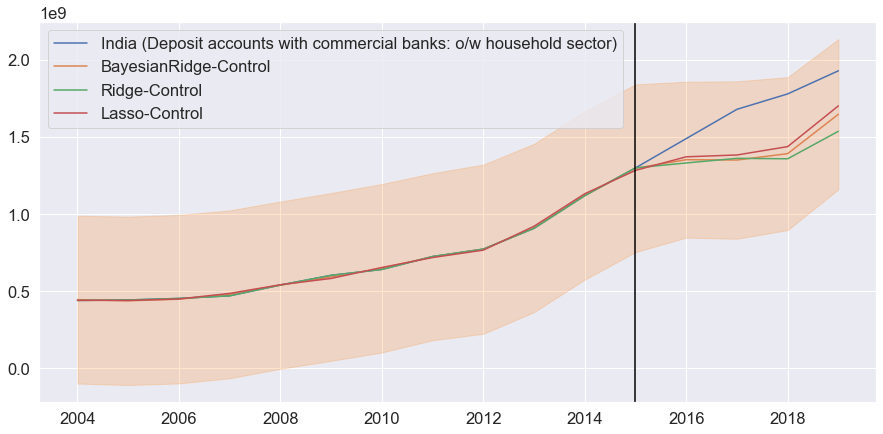

In [40]:
fig = plt.figure(figsize=(15,7))
plt.plot(np.arange(2004,2020),Y_target)
plt.plot(np.arange(2004,2020),Y_target_bayesian)
plt.plot(np.arange(2004,2020),Y_target_ridge)
plt.plot(np.arange(2004,2020),Y_target_lasso)

plt.fill_between(np.arange(2004,2020),Y_target_bayesian+std_y_target_bayesian,Y_target_bayesian-std_y_target_bayesian,alpha=0.2,color='#ff7f0e')
plt.axvline(2015,c='black')
plt.legend(['%s (%s)'%(target,series),'BayesianRidge-Control','Ridge-Control','Lasso-Control'])

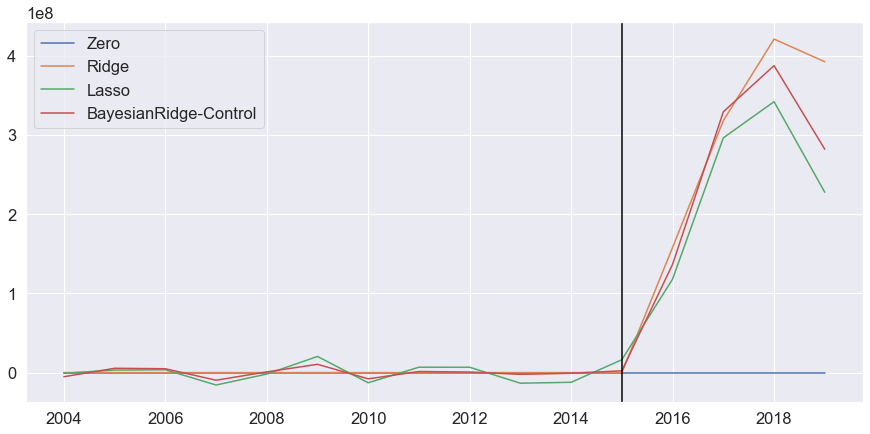

In [41]:
fig = plt.figure(figsize=(15,7))
plt.plot(np.arange(2004,2020),Y_target-Y_target)
plt.plot(np.arange(2004,2020),Y_target-Y_target_ridge)
plt.plot(np.arange(2004,2020),(Y_target.to_numpy().T-Y_target_lasso).T)
plt.plot(np.arange(2004,2020),(Y_target.to_numpy().T-Y_target_bayesian).T)
plt.axvline(2015,c='black')
plt.legend(['Zero','Ridge','Lasso','BayesianRidge-Control'])

<AxesSubplot:>

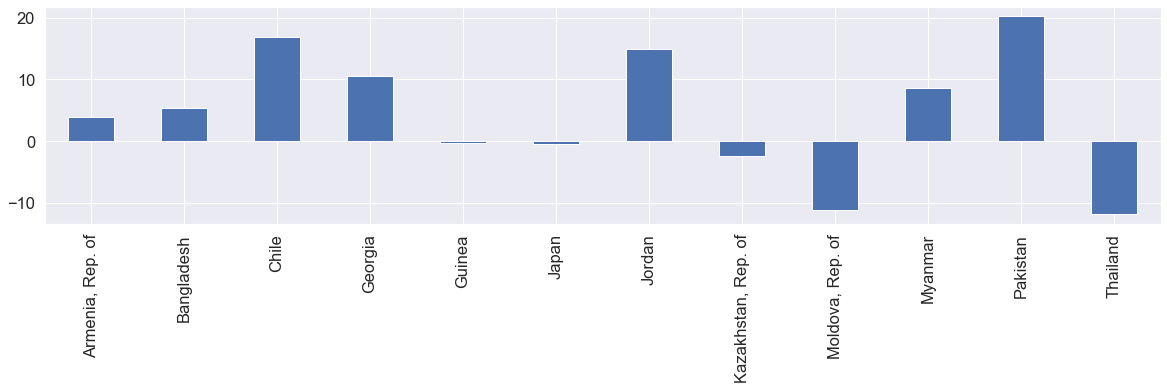

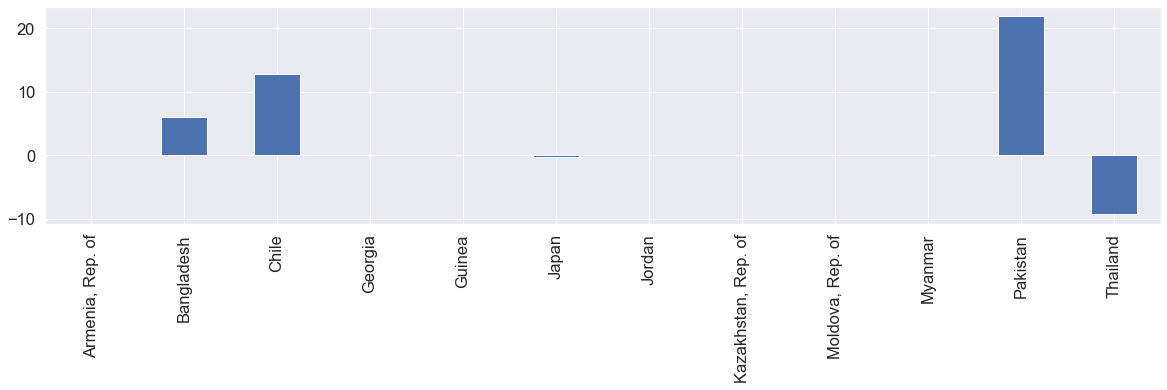

In [42]:
fig = plt.figure(figsize=(20,4))
pd.Series(m_bayesian.coef_,index=Y_donor.columns).plot(kind='bar')
fig = plt.figure(figsize=(20,4))
pd.Series(m_lasso.coef_,index=Y_donor.columns).plot(kind='bar')

# Bundles

In [48]:
bundles_names = ['Deposit accounts with commercial banks: o/w household sector',
                 'No of household sector deposit accounts with commercial banks per 1,000 adults',
                 'No of women-owned deposit acc of hh sector with commercial banks per 1,000 femal',
                 'Non-life insurance policies per 1,000 adults',
                 'Number of loan accounts with commercial banks per 1,000 adults',
                 'Loan accounts with commercial banks: o/w SME',
                 'No of household sector loan accounts with commercial banks per 1,000 adults',
                 'Number of borrowers from credit unions and credit cooperatives per 1,000 adults']


In [49]:
bundles = {}
for series in bundles_names:
    time_intervention = 2016
    target = 'India'
    donors = [ 'Argentina', 'Armenia, Rep. of', 'Bangladesh', 'Barbados', 'Belarus, Rep. of', 'Bhutan', 'Bosnia and Herzegovina', 'Botswana', 
              'Brunei Darussalam', 'Cambodia', 'Cameroon', 'Chile', 'China, P.R.: Macao', 'China, P.R.: Mainland', 'Colombia', 'Costa Rica', 'Cyprus', 
              'Egypt, Arab Rep. of', 'Fiji, Rep. of', 'Georgia', 'Guinea', 'Honduras', 'Hungary', 'Jamaica', 'Japan', 'Jordan', 
              'Kazakhstan, Rep. of', 'Korea, Rep. of', 'Kosovo, Rep. of', "Lao People's Dem. Rep.", 'Latvia', 'Lebanon', 'Lesotho, Kingdom of', 
              'Maldives', 'Mauritius', 'Mexico', 'Moldova, Rep. of', 'Montenegro', 'Myanmar', 'Nicaragua', 'North Macedonia, Republic of', 'Pakistan', 
              'Poland, Rep. of', 'Portugal', 'Romania', 'Russian Federation', 'Rwanda', 'Samoa', 'São Tomé and Príncipe, Dem. Rep. of', 'Saudi Arabia', 
              'Serbia, Rep. of', 'Seychelles', 'Slovak Rep.', 'Suriname', 'Thailand', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Ukraine', 'Vanuatu', 
              'Zambia']
    Ypre_target,Ypre_donor,Y_target,Y_donor = setup(target,donors,series,time_intervention,data)
    bundles[series] = (Ypre_target,Ypre_donor,Y_target,Y_donor)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change

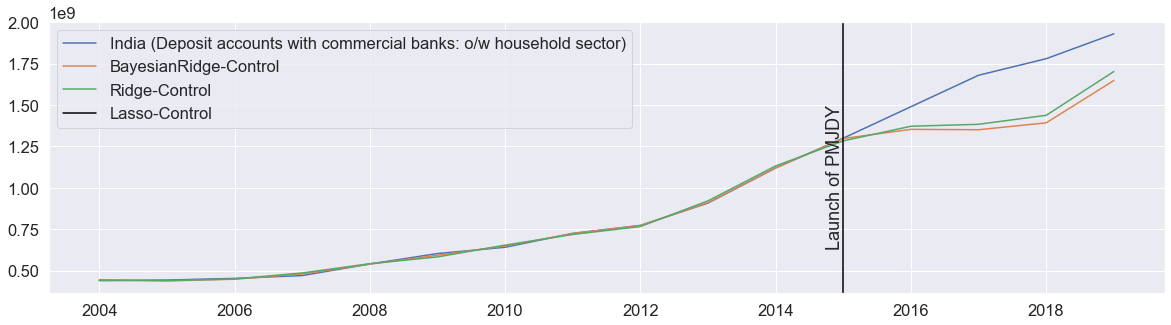

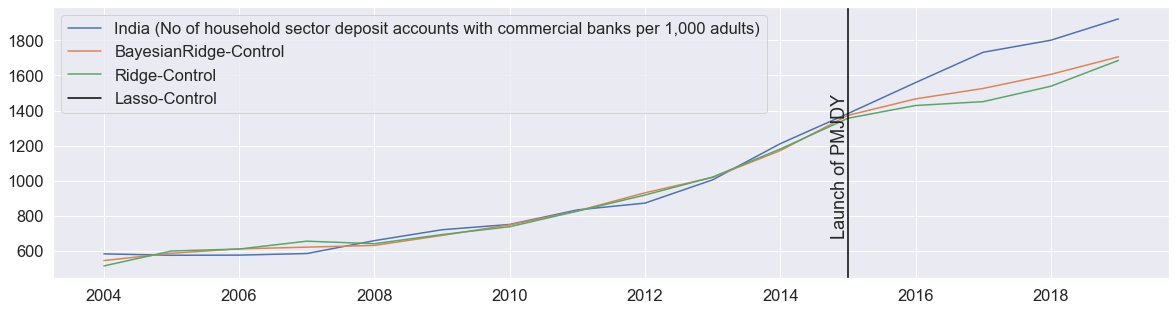

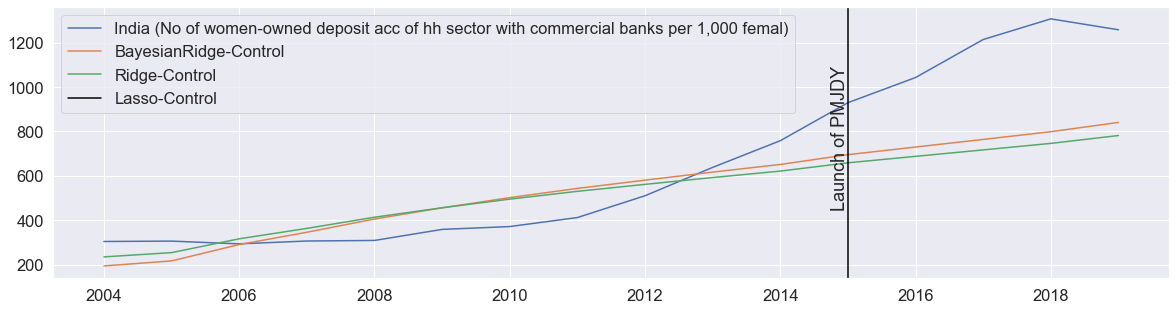

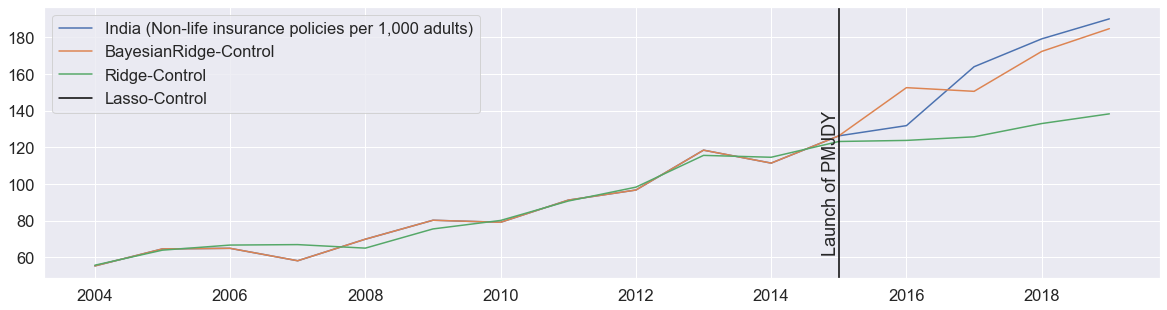

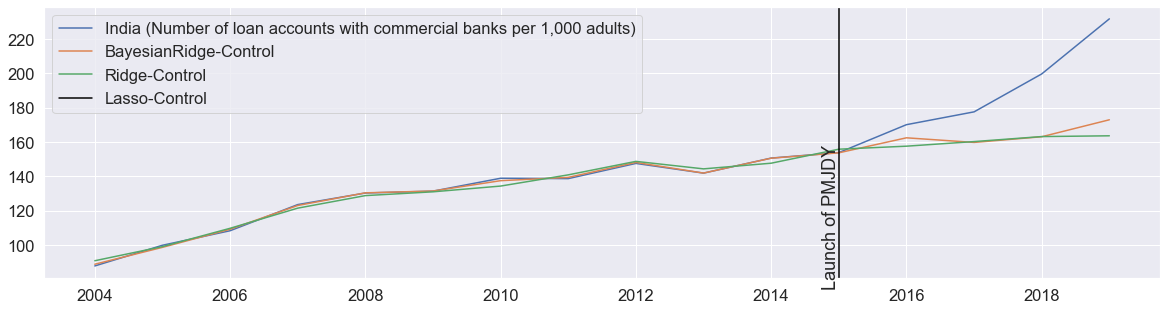

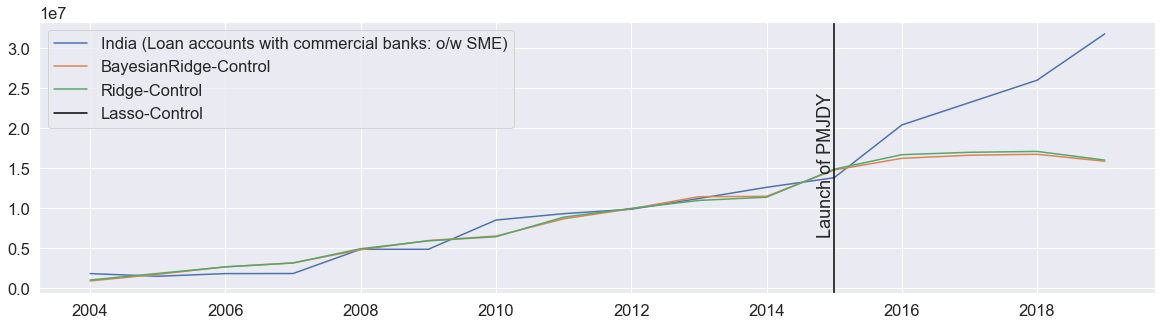

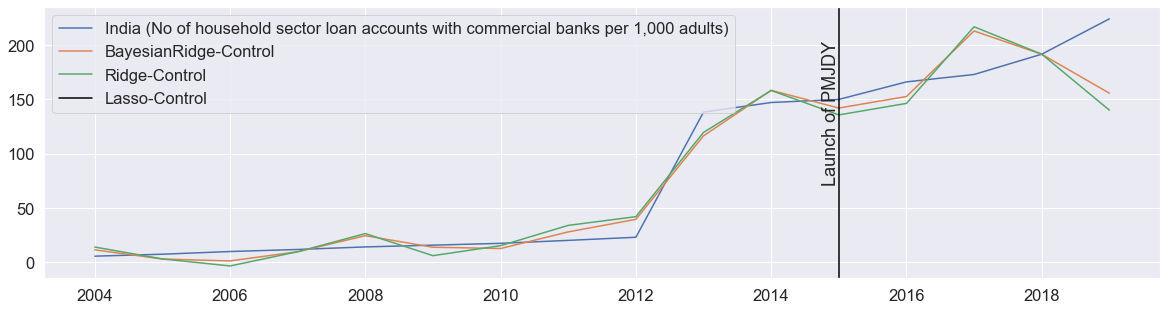

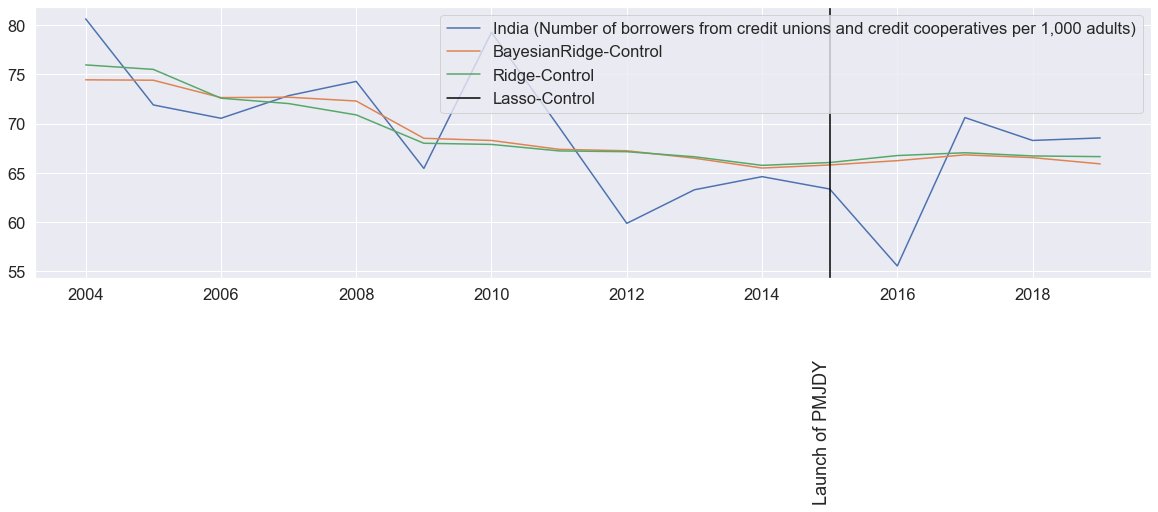

In [60]:
for series in bundles.keys():
    (Ypre_target,Ypre_donor,Y_target,Y_donor) = bundles[series]
    
    m_lasso = lm.LassoCV().fit(Ypre_donor,Ypre_target)
    m_bayesian = lm.BayesianRidge().fit(Ypre_donor,Ypre_target)
    
    Y_target_lasso = m_lasso.predict(Y_donor.fillna(method='ffill'))
    Y_target_bayesian,std_y_target_bayesian = m_bayesian.predict(Y_donor.fillna(method='ffill'),return_std=True)
    
    fig = plt.figure(figsize=(20,5))
    plt.plot(np.arange(2004,2020),Y_target)
    plt.plot(np.arange(2004,2020),Y_target_bayesian)
    plt.plot(np.arange(2004,2020),Y_target_lasso)
    plt.axvline(2015,c='black')
    plt.text(2014.75,Y_target.loc[2015]/2,'Launch of PMJDY',rotation=90)
    plt.legend(['%s (%s)'%(target,series),'BayesianRidge-Control','Ridge-Control','Lasso-Control'])
    fig.savefig('%s.png'%(target))